In [1]:
import numpy as np 
import itertools
import matplotlib.pyplot as plt
import pickle
import sys


In [2]:

#FUNCTION
def partition_N(n):
    '''do the partition of a complete graph'''
    indexs = range(n)
    pairs_all = []

    swap_even = [i + pow(-1, i) for i in range(n)]

    swap_odd = [0]
    swap_odd.extend([i + pow(-1, i+1) for i in range(1,n-1)])
    swap_odd.append(n-1)

    pairs_even = [(i, i+1) for i in range(0, n, 2)]
    indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #     print('\nindexs after swap {}: {}'.format(0, indexs))
    pairs_all.append(pairs_even)
    for i in range(1, n):
        if (i%2)==1:
            pair_odd = [(indexs[i], indexs[i+1]) for i in range(1, n-1, 2)]
            pairs_all.append(pair_odd)
            indexs = np.array(indexs)[swap_odd]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

        elif (i%2)==0:
            pair_even = [(indexs[i], indexs[i+1]) for i in range(0, n-1, 2)]
            pairs_all.append(pair_even)
            indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

    return pairs_all



In [3]:
def compute_cvar(probabilities, values, alpha):
    """
    Auxilliary method to compute the conditional value at risk.

    Args:
        probabilities (List[Real]): The probabilities for measuring a bit string
        values (List[Real]): The corresponding energy values
        alpha (Real): Confidence level for the conditional value at risk

    Returns:
        cvar (Real): The conditional value at risk
    """
    
    sorted_indices = np.argsort(values)
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]

    cvar = 0
    total_prob = 0
    for i, (p, v) in enumerate(zip(probs, vals)):
        if p >= alpha - total_prob:
            p = alpha - total_prob
        total_prob += p
        cvar += p * v
        if abs(total_prob - alpha) < 1e-8:
            break

    cvar /= total_prob

    return cvar

In [4]:
num_variables_list = [str(num).zfill(3) for num in range(6,22, 2)]

N_ins = 100 ###100 50 number of random instances

ansatz_type = 'structure_like_qubo_YZ_2' 

layer = 1

shots = None

alpha = 0.01

tau =0.3

howmany = 1
 
dir_0 = './data_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

cvar_dict_all = []
solution_dict_all = []

for num_variables in num_variables_list:

    # Initialize the dictionary using dictionary comprehension
    cvar_dict = {
    'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
    'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

    solution_dict = {
    'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
    'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

    solution_dict['old']['Random'] = []
    solution_dict['lightcone']['Random'] = []
    cvar_dict['old']['Random'] = []
    cvar_dict['lightcone']['Random'] = []

    n_qubits = int(num_variables)

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for initialization in ['warm_start_measure']:   #'warm_start_measure_lightcone'

        print('initialization', initialization, num_variables) 
        y = []

        dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                            .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in range(N_ins):
                
            file_dir_name = dir_name + '/r_{}'\
                            .format(r)
            
            #ADD THE RANDOM OPTION
            if initialization ==  'warm_start_measure':
                file_path = file_dir_name + '/tau_{}_random.pkl'\
                                                    .format(tau)
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)  

                probs = list(data['layers_exp_poss_dict']['l_1'].values())
                energies = list(data['layers_exp_poss_dict']['l_1'].keys())
                cvar = compute_cvar(probs, energies, alpha)
                cvar_dict['old']['Random'].append(cvar)

                fidelity = 0
                for item in range(howmany):            
                    fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]     
                solution_dict['old']['Random'].append(fidelity)

            # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
            #     file_path_lightcone = file_dir_name + '/tau_{}_random.pkl'\
            #                                         .format(tau)
            #     with open(file_path_lightcone, 'rb') as f:
            #         data_lightcone = pickle.load(f)            
            #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
            #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
            #     overlap = data['ite_overlap']
            #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

            else:
                sys.stderr.write('something is wrong with initialization')
                sys.exit()

            #ADD ALL THE SORTING OPTIONS
            for Abs in [True, False]:
                for invert in [True, False]:

                    if initialization ==  'warm_start_measure':
                        file_path = file_dir_name + '/tau_{}_{}_{}.pkl'\
                                                    .format(tau, Abs, invert)
                        with open(file_path, 'rb') as f:
                            data = pickle.load(f)

                        probs = list(data['layers_exp_poss_dict']['l_1'].values())
                        energies = list(data['layers_exp_poss_dict']['l_1'].keys())
                        cvar = compute_cvar(probs, energies, alpha)
                        cvar_dict['old'][f'Sort_{Abs}_{invert}'].append(cvar)

                        fidelity = 0 
                        for item in range(howmany):            
                            fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]
                        solution_dict['old'][f'Sort_{Abs}_{invert}'].append(fidelity)

                    # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
                    #     file_path_lightcone = file_dir_name + '/tau_{}_{}_{}.pkl'\
                    #                                         .format(tau, Abs, invert)
                    #     with open(file_path_lightcone, 'rb') as f:
                    #         # Load the content of the file using pickle.load()
                    #         data_lightcone = pickle.load(f)            
                    #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
                    #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
                    #     overlap = data['ite_overlap']
                    #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

                    else:
                        sys.stderr.write('something is wrong with initialization')
                        sys.exit()

    cvar_dict_all.append(cvar_dict)
    solution_dict_all.append(solution_dict)

initialization warm_start_measure 006
initialization warm_start_measure 008
initialization warm_start_measure 010
initialization warm_start_measure 012
initialization warm_start_measure 014


FileNotFoundError: [Errno 2] No such file or directory: './data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/num_variables_014/params_196_layer_1/alpha_0.01/initial_warm_start_measure/r_0/tau_0.3_random.pkl'

006 KEYS ['Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 

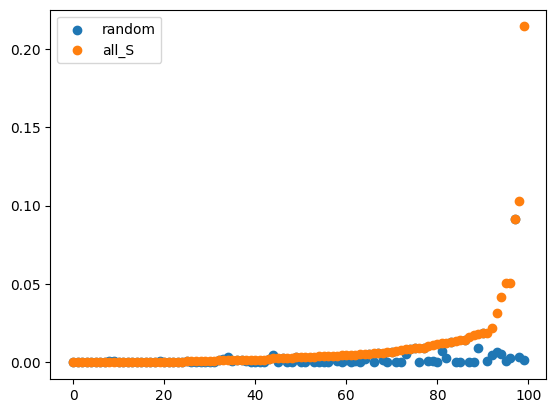

In [206]:
best_sorted_all_cvar = []
best_sorted_all_cvarfidelity = []

for j,num_variables in enumerate(num_variables_list):

    keys = [] 
    for i in range(N_ins):
        current_value = cvar_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] < current_value:
                    current_value = cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    print(num_variables, 'KEYS', keys)

    best_sorted_cvar = [ cvar_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]
    best_sorted_cvarfidelity = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cvar.append(best_sorted_cvar)
    best_sorted_all_cvarfidelity.append(best_sorted_cvarfidelity)

# sorted_ind = np.argsort(solution_dict['old']['Random'])
sorted_ind = np.argsort(best_sorted_cvar)
# plt.scatter(range(N_ins), np.array(cvar_dict['old']['Random'])[sorted_ind], label = 'random')
# plt.scatter(range(N_ins), np.array(best_sorted_cvar)[sorted_ind], label = 'all_S')
# plt.legend()

sorted_ind = np.argsort(best_sorted_cvarfidelity)
plt.scatter(range(N_ins), np.array(solution_dict['old']['Random'])[sorted_ind], label = 'random')
plt.scatter(range(N_ins), np.array(best_sorted_cvarfidelity)[sorted_ind], label = 'all_S')
plt.legend()

In [207]:
#CHEATING SORTING

######################################################
#Try to sort adaptively CHEATING - old style 

best_sorted_all_cheat = []

for j,num_variables in enumerate(num_variables_list):

    keys = [] 
    for i in range(N_ins):
        current_value = solution_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] > current_value:
                    current_value = solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    best_sorted_cheat = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cheat.append(best_sorted_cheat)


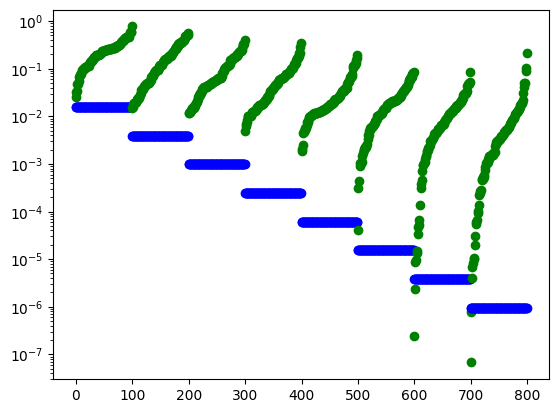

In [208]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    # plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

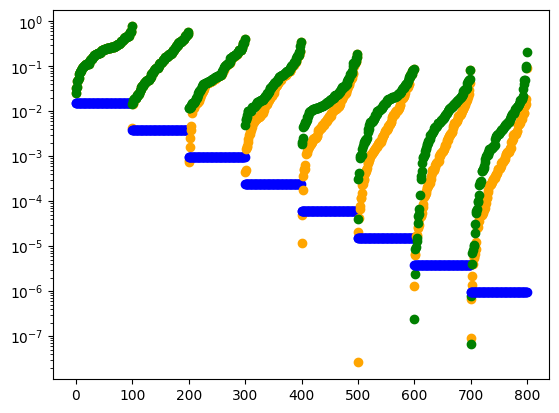

In [209]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    # plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

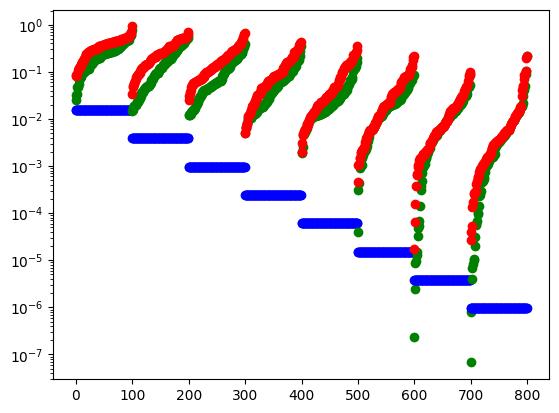

In [210]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

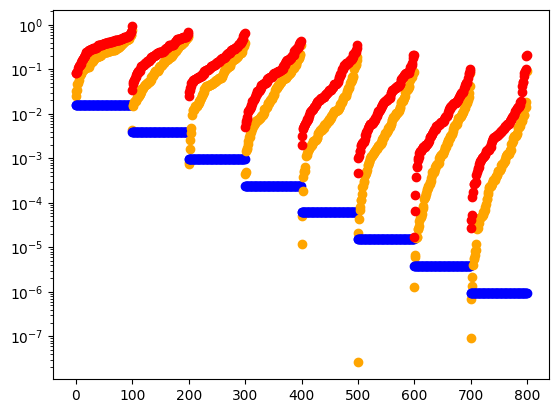

In [211]:
for j,num_variables in enumerate(num_variables_list):
    n_qubits = int(num_variables)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    #plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

TRY N=20 CMOPARE TAU

In [212]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)]

N_ins = 100 ###100 50 number of random instances

ansatz_type = 'structure_like_qubo_YZ_2' 

layer = 1

shots = None

alpha = 0.01

tau_list = [0.3, 0.4, 0.6, 0.8, 1.0] 

dir_0 = './data_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

cvar_dict_all = []
solution_dict_all = []

for tau in tau_list:

    for num_variables in num_variables_list:

        # Initialize the dictionary using dictionary comprehension
        cvar_dict = {
        'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
        'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

        solution_dict = {
        'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
        'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

        solution_dict['old']['Random'] = []
        solution_dict['lightcone']['Random'] = []
        cvar_dict['old']['Random'] = []
        cvar_dict['lightcone']['Random'] = []

        n_qubits = int(num_variables)

        pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
        num_pairs = len(pairs_all)
        num_params = (n_qubits + 2*num_pairs) * layer

        for initialization in ['warm_start_measure']:   #'warm_start_measure_lightcone'

            print('initialization', initialization, num_variables, tau) 
            y = []

            dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                                .format(num_variables, num_params, layer, alpha, initialization)
            
            for r in range(N_ins):
                    
                file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                
                #ADD THE RANDOM OPTION
                if initialization ==  'warm_start_measure':
                    file_path = file_dir_name + '/tau_{}_random.pkl'\
                                                        .format(tau)
                    with open(file_path, 'rb') as f:
                        data = pickle.load(f)  

                    probs = list(data['layers_exp_poss_dict']['l_1'].values())
                    energies = list(data['layers_exp_poss_dict']['l_1'].keys())
                    cvar = compute_cvar(probs, energies, alpha)
                    cvar_dict['old']['Random'].append(cvar)

                    fidelity = 0
                    for item in range(howmany):            
                        fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]     
                    solution_dict['old']['Random'].append(fidelity)

                # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
                #     file_path_lightcone = file_dir_name + '/tau_{}_random.pkl'\
                #                                         .format(tau)
                #     with open(file_path_lightcone, 'rb') as f:
                #         data_lightcone = pickle.load(f)            
                #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
                #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
                #     overlap = data['ite_overlap']
                #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

                else:
                    sys.stderr.write('something is wrong with initialization')
                    sys.exit()

                #ADD ALL THE SORTING OPTIONS
                for Abs in [True, False]:
                    for invert in [True, False]:

                        if initialization ==  'warm_start_measure':
                            file_path = file_dir_name + '/tau_{}_{}_{}.pkl'\
                                                        .format(tau, Abs, invert)
                            with open(file_path, 'rb') as f:
                                data = pickle.load(f)

                            probs = list(data['layers_exp_poss_dict']['l_1'].values())
                            energies = list(data['layers_exp_poss_dict']['l_1'].keys())
                            cvar = compute_cvar(probs, energies, alpha)
                            cvar_dict['old'][f'Sort_{Abs}_{invert}'].append(cvar)

                            fidelity = 0 
                            for item in range(howmany):            
                                fidelity += list(data['layers_exp_poss_dict']['l_1'].items())[item][1]
                            solution_dict['old'][f'Sort_{Abs}_{invert}'].append(fidelity)

                        # elif initialization == 'warm_start_measure_lightcone':   #MODIFY
                        #     file_path_lightcone = file_dir_name + '/tau_{}_{}_{}.pkl'\
                        #                                         .format(tau, Abs, invert)
                        #     with open(file_path_lightcone, 'rb') as f:
                        #         # Load the content of the file using pickle.load()
                        #         data_lightcone = pickle.load(f)            
                        #     fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
                        #     solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(fidelity)
                        #     overlap = data['ite_overlap']
                        #     iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(overlap)

                        else:
                            sys.stderr.write('something is wrong with initialization')
                            sys.exit()

    cvar_dict_all.append(cvar_dict)
    solution_dict_all.append(solution_dict)

initialization warm_start_measure 020 0.3
initialization warm_start_measure 020 0.4
initialization warm_start_measure 020 0.6
initialization warm_start_measure 020 0.8
initialization warm_start_measure 020 1.0


In [213]:
print(len(cvar_dict_all))

5


0.3 KEYS ['Sort_False_False', 'Sort_True_True', 'Sort_False_False', 'Random', 'Sort_True_True', 'Sort_True_True', 'Random', 'Sort_True_False', 'Sort_False_True', 'Sort_True_True', 'Sort_True_True', 'Sort_False_False', 'Sort_True_False', 'Sort_False_True', 'Sort_True_True', 'Sort_False_True', 'Random', 'Sort_False_True', 'Random', 'Sort_False_True', 'Sort_True_True', 'Sort_True_False', 'Sort_False_True', 'Random', 'Sort_True_False', 'Sort_True_False', 'Sort_False_False', 'Sort_False_True', 'Sort_False_True', 'Random', 'Random', 'Sort_False_True', 'Sort_True_True', 'Sort_False_True', 'Sort_False_True', 'Sort_True_True', 'Sort_True_True', 'Sort_False_False', 'Sort_True_True', 'Random', 'Sort_False_False', 'Sort_False_False', 'Random', 'Sort_False_True', 'Sort_True_True', 'Sort_False_False', 'Sort_True_False', 'Sort_False_False', 'Sort_True_True', 'Sort_True_True', 'Sort_True_False', 'Sort_False_False', 'Sort_False_False', 'Sort_False_True', 'Sort_True_True', 'Sort_True_True', 'Sort_False_

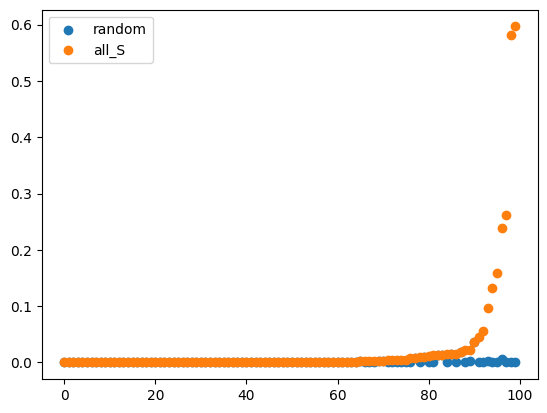

In [214]:
best_sorted_all_cvar = []
best_sorted_all_cvarfidelity = []

num_variables = 20

for j,tau in enumerate(tau_list):

    keys = [] 
    for i in range(N_ins):
        current_value = cvar_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] < current_value:
                    current_value = cvar_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    print(tau, 'KEYS', keys)

    best_sorted_cvar = [ cvar_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]
    best_sorted_cvarfidelity = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cvar.append(best_sorted_cvar)
    best_sorted_all_cvarfidelity.append(best_sorted_cvarfidelity)

# sorted_ind = np.argsort(solution_dict['old']['Random'])
sorted_ind = np.argsort(best_sorted_cvar)
# plt.scatter(range(N_ins), np.array(cvar_dict['old']['Random'])[sorted_ind], label = 'random')
# plt.scatter(range(N_ins), np.array(best_sorted_cvar)[sorted_ind], label = 'all_S')
# plt.legend()

sorted_ind = np.argsort(best_sorted_cvarfidelity)
plt.scatter(range(N_ins), np.array(solution_dict['old']['Random'])[sorted_ind], label = 'random')
plt.scatter(range(N_ins), np.array(best_sorted_cvarfidelity)[sorted_ind], label = 'all_S')
plt.legend()

#CHEATING SORTING

######################################################
#Try to sort adaptively CHEATING - old style 

best_sorted_all_cheat = []

for j,tau in enumerate(tau_list):

    keys = [] 
    for i in range(N_ins):
        current_value = solution_dict_all[j]['old']['Random'][i]
        new_key = 'Random'

        for Abs in [True, False]:
            for invert in [True, False]: 
                if solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i] > current_value:
                    current_value = solution_dict_all[j]['old'][f'Sort_{Abs}_{invert}'][i]
                    new_key = f'Sort_{Abs}_{invert}'
        keys.append(new_key)

    best_sorted_cheat = [ solution_dict_all[j]['old'].get(key)[i] for i,key in enumerate(keys) ]

    best_sorted_all_cheat.append(best_sorted_cheat)

3.0
4.0
6.0
8.0
10.0


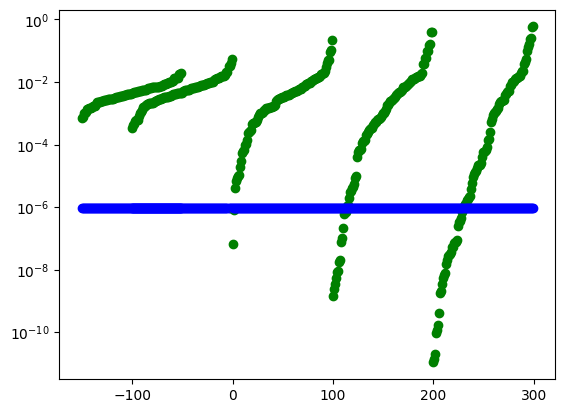

In [215]:
for j,tau in enumerate(tau_list):
    n_qubits = 10*tau
    print(n_qubits)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    #plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

3.0
4.0
6.0
8.0
10.0


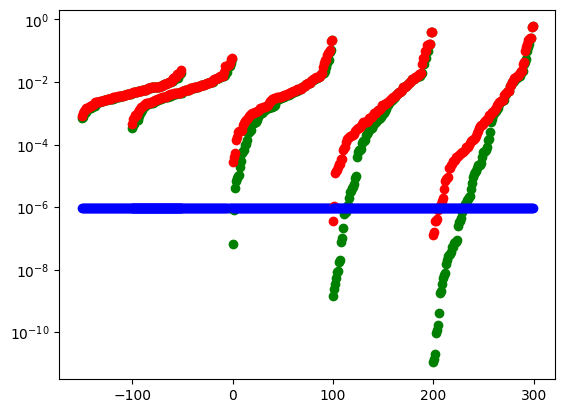

In [216]:
for j,tau in enumerate(tau_list):
    n_qubits = 10*tau
    print(n_qubits)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    #plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()

3.0
4.0
6.0
8.0
10.0


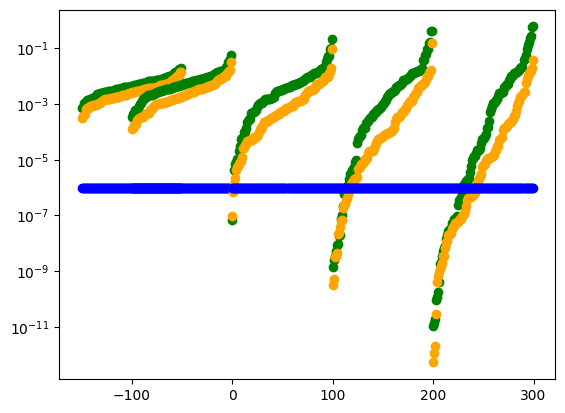

In [217]:
for j,tau in enumerate(tau_list):
    n_qubits = 10*tau
    print(n_qubits)

    x = np.arange(N_ins)
    y4 = [1/(2**float(num_variables)) for X in x]

    plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cvarfidelity[j]), label = 'sort', color='green')
    plt.scatter(x+50*(n_qubits-6), sorted(solution_dict_all[j]['old']['Random']), label = 'sort', color='orange')
    #plt.scatter(x+50*(n_qubits-6), sorted(best_sorted_all_cheat[j]), label = 'sort', color='red')
    plt.scatter(x+50*(n_qubits-6), y4, label = 'random', color='blue')
    plt.yscale('log')
    # plt.legend()